In [1]:
import sys
sys.path.append("../")
from utils import load_cnf, cnf_to_bqm
from embedding_utils import *
import seaborn as sns
from redundancy import *
from utils import *
from dwave.embedding.chain_strength import scaled
import pandas as pd
from brute_force import get_bqm_random_sat
import numpy as np
import matplotlib.pyplot as plt
from statistics import variance
from greedy import SteepestDescentSolver

In [2]:
one_answer = 9223372036854775807
thresholds = [1, 4611686018427387903, 9223372036854775807, 13835058055282163711, 18446744073709551615]
qpu = get_qpu()
quimera_qpu = DWaveSampler(solver={"name": "DW_2000Q_6"})
solver_greedy = SteepestDescentSolver()

In [3]:
def get_vertices_degrees(bqm):
    answer = []
    for (node, neighbours) in bqm.adj.items():
        answer.append(len(neighbours)) 
    return answer

def get_file_bqm(file_name):
    bqm, estimated_num_variables = unicorn_file_parser(f"./sat_ratio/{file_name}.unicorn")
    vertices_degrees = get_vertices_degrees(bqm)
    avg_degrees = round(float(sum(vertices_degrees))/float(len(vertices_degrees)),2)
    variance_degrees = round(variance(vertices_degrees),2)
    
    num_variables, num_clauses, variables, clauses = load_cnf(f"./sat_ratio/{file_name}.cnf")
    print(f"file: {file_name}")
    print(f"cnf vars, clauses, clauses_to_var = {num_variables}, {num_clauses}, {round(num_clauses/num_variables,2)}")
    print(f"qubo vars {len(bqm.variables)}")
    print(f"conn avg, variance, max = {avg_degrees}, {variance_degrees}, {max(vertices_degrees)}")
    
    return bqm

In [4]:
def get_input_value(sample, one_input):
    answer = 0
    for (index,element) in enumerate(one_input):
        answer+= (sample[element])*(2**index)
    return int(answer)

def get_input_values(sample, input_ids):
    answer = []
    
    for i in input_ids:
        answer.append(get_input_value(sample, i))
    return ','.join([str(x) for x in answer]) 

In [73]:
def get_results_dataframe(file, input_ids, reads=100, bottom=0.25, top=5, is_pegasus=True, is_chimera=True, is_local_search=True):
    bqm = get_file_bqm(file)
    
    embedding_1, random_seed = find_best_embedding(bqm, qpu)
    sampler = FixedEmbeddingComposite(qpu, embedding_1)
    
    chain_strengths = []
    energies = []
    input_vals = []
    file_name = []
    sampleset_types = []
    qpus = []
    if is_pegasus:
        for chain_strength in list(np.arange(bottom, top + 0.25, 0.25)):
            sampleset = sampler.sample(bqm, num_reads=reads, chain_strength=chain_strength, auto_scale=True)
            print("advantage:",chain_strength, "raw", sampleset.first.energy)
            for sample in sampleset:
                file_name.append(file)
                chain_strengths.append(chain_strength)
                energies.append(bqm.energy(sample))
                sampleset_types.append("raw")
                qpus.append("Advantage4.1")
                input_vals.append(get_input_values(sample, input_ids))

            if is_local_search:
                sampleset_pp = solver_greedy.sample(bqm, initial_states=sampleset)
                print(chain_strength, "pp_local_search", sampleset.first.energy)
                for sample in sampleset:
                    file_name.append(file)
                    chain_strengths.append(chain_strength)
                    energies.append(bqm.energy(sample))
                    input_vals.append(get_input_values(sample, input_ids))
                    qpus.append("Advantage4.1")
                    sampleset_types.append("pp_local_search")
                print("************")
    if is_chimera:
        embedding_2, random_seed = find_best_embedding(bqm, quimera_qpu)
        sampler = FixedEmbeddingComposite(quimera_qpu, embedding_2)
        for chain_strength in list(np.arange(bottom, top + 0.25, 0.25)):
            sampleset = sampler.sample(bqm, num_reads=reads, chain_strength=chain_strength, auto_scale=True)
            print('chimera:',chain_strength, "raw", sampleset.first.energy)
            for sample in sampleset:
                file_name.append(file)
                chain_strengths.append(chain_strength)
                energies.append(bqm.energy(sample))
                sampleset_types.append("raw")
                qpus.append("DW_2000Q_6")
                input_vals.append(get_input_values(sample, input_ids))
            if is_local_search:
                sampleset_pp = solver_greedy.sample(bqm, initial_states=sampleset)
                print(chain_strength, "pp_local_search", sampleset.first.energy)
                for sample in sampleset_pp:
                    file_name.append(file)
                    chain_strengths.append(chain_strength)
                    energies.append(bqm.energy(sample))
                    input_vals.append(get_input_values(sample, input_ids))
                    qpus.append("DW_2000Q_6")
                    sampleset_types.append("pp_local_search")
                print("************")
        
    return pd.DataFrame({
        'file': file_name,
        'type': sampleset_types,
        'chain_strength': chain_strengths,
        'energy': energies,
        'input_values': input_vals,
        'qpu': qpus
    })

# Just one answer (EASY)

In [52]:
input_ids = [[2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115,117,119,121,123,125,127]]
file = "1"
df = get_results_dataframe(file, input_ids)
df.to_csv('sat_ratio/outputs/1.csv' )
df

file: 1
cnf vars, clauses, clauses_to_var = 128, 192, 1.5
qubo vars 127
conn avg, variance, max = 2.96, 1.02, 4
best embedding random_seed 56
best embedding max_chain_length 2
best embedding qubits used 128
best embedding variance: 0.007874015748031496
advantage: 0.25 raw 2.0
0.25 pp_local_search 2.0
************
advantage: 0.5 raw 2.0
0.5 pp_local_search 2.0
************
advantage: 0.75 raw 2.0
0.75 pp_local_search 2.0
************
advantage: 1.0 raw 2.0
1.0 pp_local_search 2.0
************
advantage: 1.25 raw 2.0
1.25 pp_local_search 2.0
************
advantage: 1.5 raw 2.0
1.5 pp_local_search 2.0
************
advantage: 1.75 raw 2.0
1.75 pp_local_search 2.0
************
advantage: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
advantage: 2.25 raw 2.0
2.25 pp_local_search 2.0
************
advantage: 2.5 raw 2.0
2.5 pp_local_search 2.0
************
advantage: 2.75 raw 2.0
2.75 pp_local_search 2.0
************
advantage: 3.0 raw 2.0
3.0 pp_local_search 2.0
************
advantage: 3.25

KeyboardInterrupt: embedding cancelled by keyboard interrupt

<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

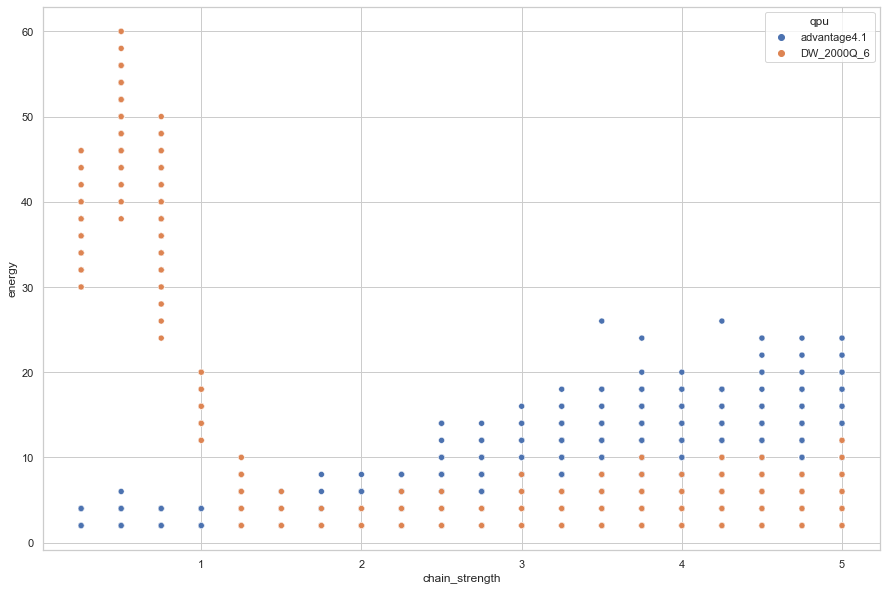

In [13]:
df = pd.read_csv('sat_ratio/outputs/1.csv')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df[df.type=='raw'], x="chain_strength", y="energy", hue="qpu")

# Just one answer

In [40]:
# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p1"
# df = get_results_dataframe(file, input_ids)
# df.to_csv('sat_ratio/outputs/p1.csv' )
# df


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

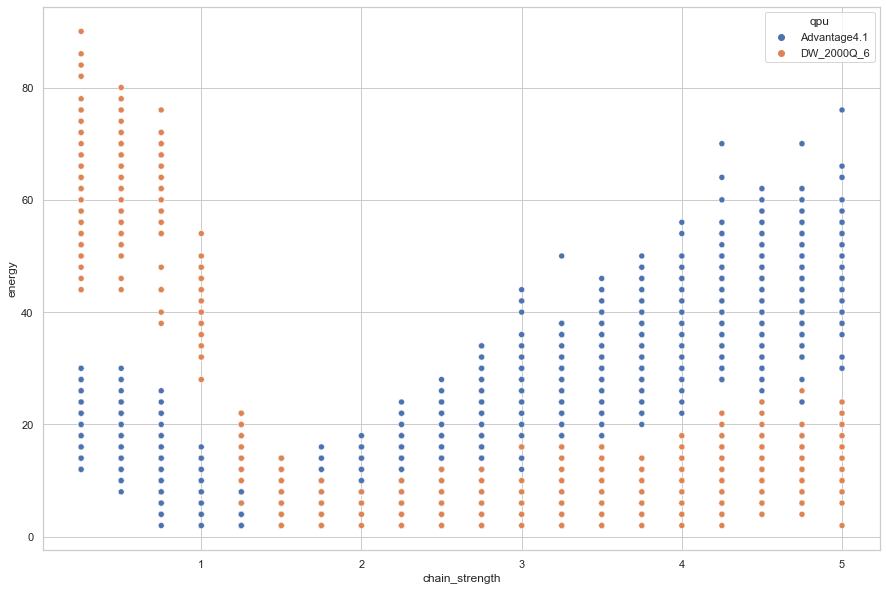

In [12]:
df = pd.read_csv('sat_ratio/outputs/p1.csv')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df[df.type=='raw'], x="chain_strength", y="energy", hue="qpu")

# 25% are answers

In [6]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p25"
df = get_results_dataframe(file, input_ids)
df.to_csv('sat_ratio/outputs/p25.csv' )
df

file: p25
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 80
best embedding max_chain_length 2
best embedding qubits used 264
best embedding variance: 0.04175293305728089
advantage: 0.25 raw 14.0
0.25 pp_local_search 14.0
************
advantage: 0.5 raw 8.0
0.5 pp_local_search 8.0
************
advantage: 0.75 raw 0.0
0.75 pp_local_search 0.0
************
advantage: 1.0 raw 0.0
1.0 pp_local_search 0.0
************
advantage: 1.25 raw 0.0
1.25 pp_local_search 0.0
************
advantage: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
advantage: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
advantage: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
advantage: 2.25 raw 2.0
2.25 pp_local_search 2.0
************
advantage: 2.5 raw 2.0
2.5 pp_local_search 2.0
************
advantage: 2.75 raw 8.0
2.75 pp_local_search 8.0
************
advantage: 3.0 raw 12.0
3.0 pp_local_search 12.0
************
advantage

,file,type,chain_strength,energy,input_values,qpu
0,p25,raw,0.25,14.0,2293429721623428864,Advantage4.1
1,p25,raw,0.25,16.0,3458764505794953216,Advantage4.1
2,p25,raw,0.25,16.0,2284729131423680000,Advantage4.1
3,p25,raw,0.25,16.0,4021047610647267328,Advantage4.1
4,p25,raw,0.25,18.0,2158303593494678528,Advantage4.1
...,...,...,...,...,...,...
7991,p25,pp_local_search,5.00,20.0,1942485418586091776,DW_2000Q_6
7992,p25,pp_local_search,5.00,22.0,4519301875727978496,DW_2000Q_6
7993,p25,pp_local_search,5.00,22.0,5208400454063313920,DW_2000Q_6
7994,p25,pp_local_search,5.00,22.0,6762539412015214592,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

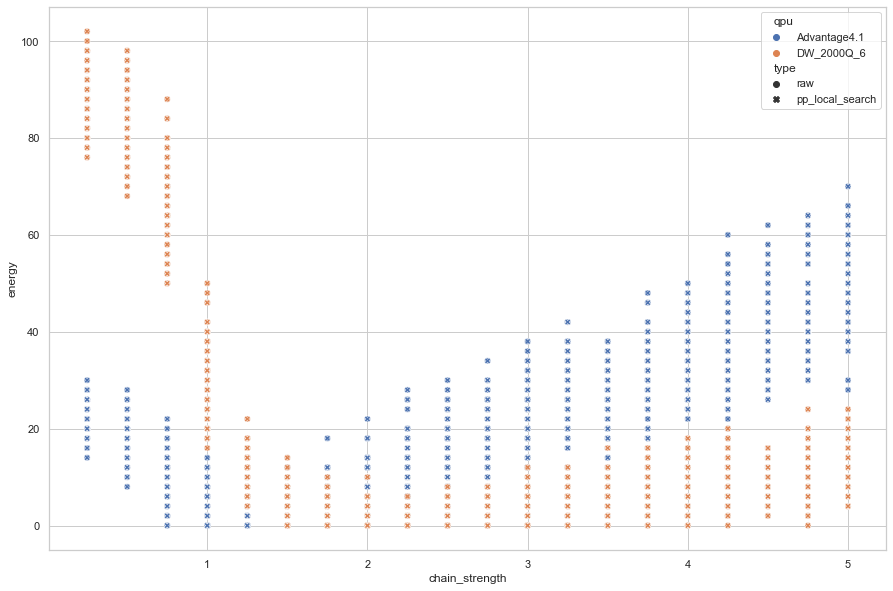

In [15]:
df = pd.read_csv('sat_ratio/outputs/p25.csv')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu", style="type")

# 50% are answers

In [18]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p50"
df = get_results_dataframe(file, input_ids)
df.to_csv('sat_ratio/outputs/p50.csv' )
df

file: p50
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 80
best embedding max_chain_length 2
best embedding qubits used 264
best embedding variance: 0.04175293305728089
advantage: 0.25 raw 14.0
0.25 pp_local_search 14.0
************
advantage: 0.5 raw 4.0
0.5 pp_local_search 4.0
************
advantage: 0.75 raw 0.0
0.75 pp_local_search 0.0
************
advantage: 1.0 raw 0.0
1.0 pp_local_search 0.0
************
advantage: 1.25 raw 0.0
1.25 pp_local_search 0.0
************
advantage: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
advantage: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
advantage: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
advantage: 2.25 raw 2.0
2.25 pp_local_search 2.0
************
advantage: 2.5 raw 2.0
2.5 pp_local_search 2.0
************
advantage: 2.75 raw 6.0
2.75 pp_local_search 6.0
************
advantage: 3.0 raw 6.0
3.0 pp_local_search 6.0
************
advantage: 

,file,type,chain_strength,energy,input_values,qpu
0,p50,raw,0.25,14.0,3636083399212506624,Advantage4.1
1,p50,raw,0.25,14.0,2863149505520623616,Advantage4.1
2,p50,raw,0.25,16.0,5039403975874082816,Advantage4.1
3,p50,raw,0.25,16.0,7180333430233157632,Advantage4.1
4,p50,raw,0.25,18.0,9075316196521158656,Advantage4.1
...,...,...,...,...,...,...
7983,p50,pp_local_search,5.00,20.0,8778015635310752768,DW_2000Q_6
7984,p50,pp_local_search,5.00,20.0,8606871141890417664,DW_2000Q_6
7985,p50,pp_local_search,5.00,22.0,1101005000958011264,DW_2000Q_6
7986,p50,pp_local_search,5.00,22.0,11300546958593495040,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

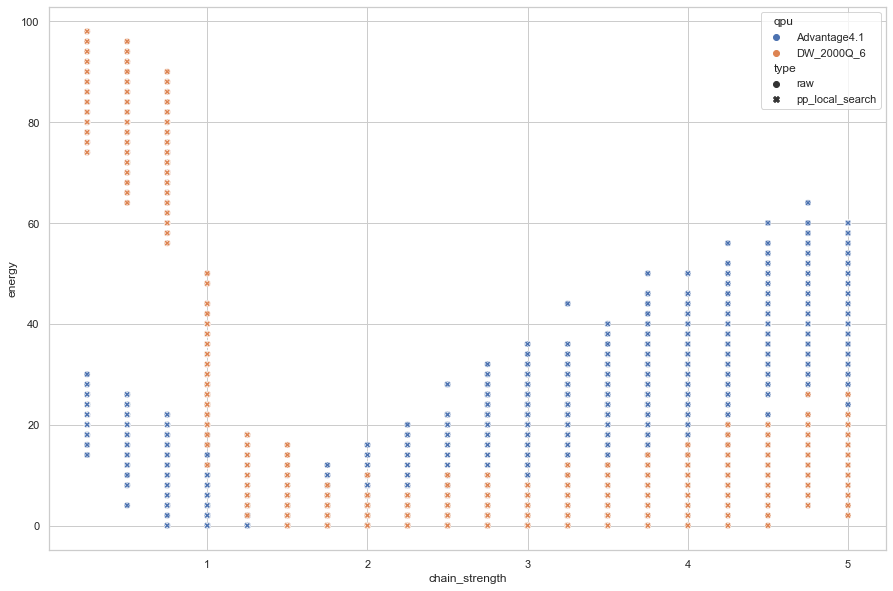

In [27]:
df = pd.read_csv('sat_ratio/outputs/p50.csv')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu", style="type")

# 75% are answers

In [20]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p75"
df = get_results_dataframe(file, input_ids)
df.to_csv('sat_ratio/outputs/p75.csv' )
df

file: p75
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 80
best embedding max_chain_length 2
best embedding qubits used 264
best embedding variance: 0.04175293305728089
advantage: 0.25 raw 12.0
0.25 pp_local_search 12.0
************
advantage: 0.5 raw 8.0
0.5 pp_local_search 8.0
************
advantage: 0.75 raw 0.0
0.75 pp_local_search 0.0
************
advantage: 1.0 raw 0.0
1.0 pp_local_search 0.0
************
advantage: 1.25 raw 0.0
1.25 pp_local_search 0.0
************
advantage: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
advantage: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
advantage: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
advantage: 2.25 raw 2.0
2.25 pp_local_search 2.0
************
advantage: 2.5 raw 4.0
2.5 pp_local_search 4.0
************
advantage: 2.75 raw 2.0
2.75 pp_local_search 2.0
************
advantage: 3.0 raw 6.0
3.0 pp_local_search 6.0
************
advantage: 

,file,type,chain_strength,energy,input_values,qpu
0,p75,raw,0.25,12.0,906720983397263488,Advantage4.1
1,p75,raw,0.25,16.0,6194701282915202048,Advantage4.1
2,p75,raw,0.25,16.0,4005951861996362240,Advantage4.1
3,p75,raw,0.25,16.0,6423246972051997696,Advantage4.1
4,p75,raw,0.25,16.0,12597673915280420864,Advantage4.1
...,...,...,...,...,...,...
7987,p75,pp_local_search,5.00,22.0,10888485344100775936,DW_2000Q_6
7988,p75,pp_local_search,5.00,22.0,3504818999574434816,DW_2000Q_6
7989,p75,pp_local_search,5.00,24.0,9694107464650100736,DW_2000Q_6
7990,p75,pp_local_search,5.00,24.0,1668455835841089280,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

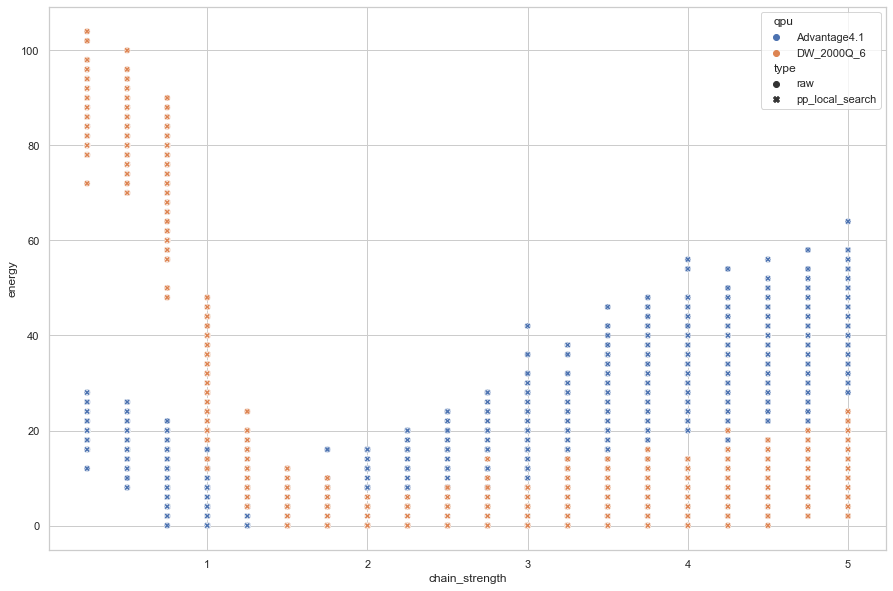

In [28]:
df = pd.read_csv('sat_ratio/outputs/p75.csv')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu", style="type")

# 99% are answers

In [22]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p100"
df = get_results_dataframe(file, input_ids)
df.to_csv('sat_ratio/outputs/p100.csv' )
df

file: p100
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 80
best embedding max_chain_length 2
best embedding qubits used 264
best embedding variance: 0.04175293305728089
advantage: 0.25 raw 14.0
0.25 pp_local_search 14.0
************
advantage: 0.5 raw 4.0
0.5 pp_local_search 4.0
************
advantage: 0.75 raw 2.0
0.75 pp_local_search 2.0
************
advantage: 1.0 raw 0.0
1.0 pp_local_search 0.0
************
advantage: 1.25 raw 0.0
1.25 pp_local_search 0.0
************
advantage: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
advantage: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
advantage: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
advantage: 2.25 raw 0.0
2.25 pp_local_search 0.0
************
advantage: 2.5 raw 4.0
2.5 pp_local_search 4.0
************
advantage: 2.75 raw 2.0
2.75 pp_local_search 2.0
************
advantage: 3.0 raw 2.0
3.0 pp_local_search 2.0
************
advantage:

,file,type,chain_strength,energy,input_values,qpu
0,p100,raw,0.25,14.0,16684209028699219968,Advantage4.1
1,p100,raw,0.25,16.0,2145732572075917312,Advantage4.1
2,p100,raw,0.25,16.0,11186923810929500160,Advantage4.1
3,p100,raw,0.25,16.0,7344736737484072960,Advantage4.1
4,p100,raw,0.25,16.0,8575894543994401792,Advantage4.1
...,...,...,...,...,...,...
7987,p100,pp_local_search,5.00,20.0,2367640349330525184,DW_2000Q_6
7988,p100,pp_local_search,5.00,20.0,15459660057904275456,DW_2000Q_6
7989,p100,pp_local_search,5.00,22.0,6850326708303584256,DW_2000Q_6
7990,p100,pp_local_search,5.00,22.0,4998708501206735872,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

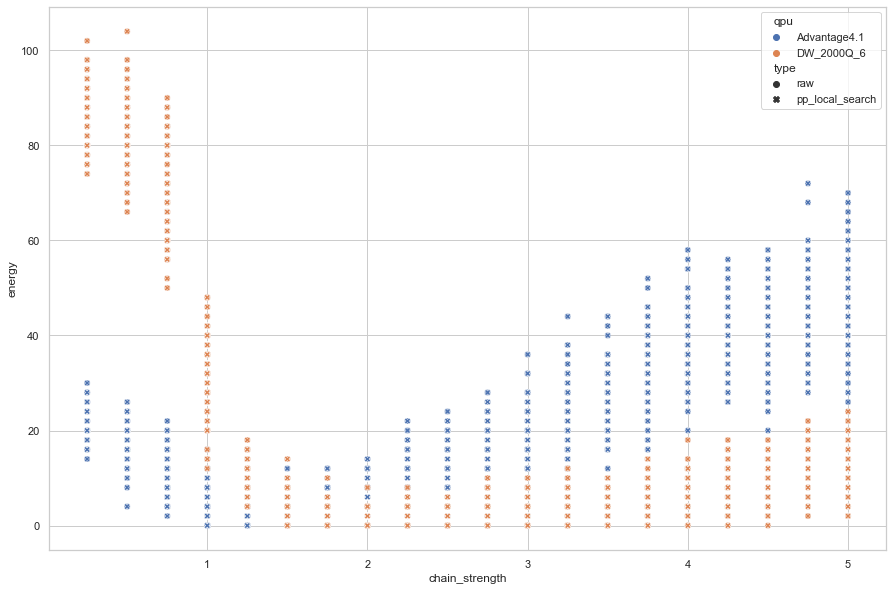

In [29]:
df = pd.read_csv('sat_ratio/outputs/p100.csv')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu", style="type")

# Merging Results

In [47]:
df_all = pd.DataFrame()
for name in ['p1', 'p25', 'p50', 'p75', 'p100']:
    df = pd.read_csv(f'sat_ratio/outputs/{name}.csv')
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df[df.type != 'raw']
    df = df[df.qpu == 'DW_2000Q_6']
    df_all = df_all.append(df)
df_all

,file,type,chain_strength,energy,input_values,qpu
4095,p1,pp_local_search,0.25,44.0,2251800887427072,DW_2000Q_6
4096,p1,pp_local_search,0.25,44.0,2251800887427072,DW_2000Q_6
4097,p1,pp_local_search,0.25,46.0,11259000142169600,DW_2000Q_6
4098,p1,pp_local_search,0.25,48.0,11259000142168064,DW_2000Q_6
4099,p1,pp_local_search,0.25,50.0,2251800887428608,DW_2000Q_6
...,...,...,...,...,...,...
7987,p100,pp_local_search,5.00,20.0,2367640349330525184,DW_2000Q_6
7988,p100,pp_local_search,5.00,20.0,15459660057904275456,DW_2000Q_6
7989,p100,pp_local_search,5.00,22.0,6850326708303584256,DW_2000Q_6
7990,p100,pp_local_search,5.00,22.0,4998708501206735872,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

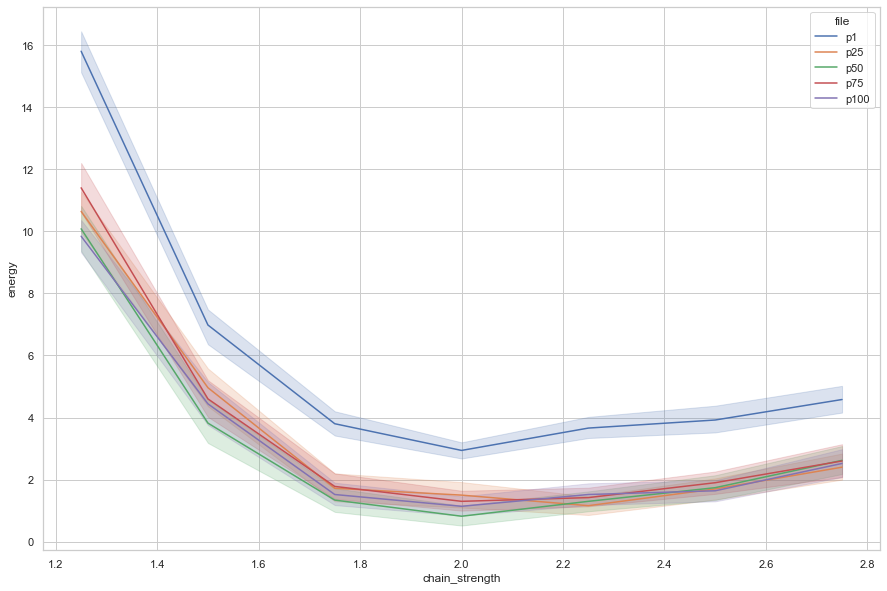

In [50]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=df_all[(df_all.chain_strength>1) & (df_all.chain_strength<3) ], x="chain_strength", y="energy", hue="file")

In [71]:
file_names = []
chain_strengths = []
counts = []
for name in ['p1', 'p25', 'p50', 'p75', 'p100']:
    df = pd.read_csv(f'sat_ratio/outputs/{name}.csv')
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df[df.type != 'raw']
    df = df[df.qpu == 'DW_2000Q_6']
    for chain_strength in list(np.arange(0.25, 5 + 0.25, 0.25)):
        file_names.append(name)
        chain_strengths.append(chain_strength)
        counts.append(df[(df.energy ==0) & (df.chain_strength == chain_strength)].shape[0])
df_energy_0_counts = pd.DataFrame({
    'file': file_names,
    'chain_strength': chain_strengths,
    'zero_energy_count': counts
})
df_energy_0_counts

,file,chain_strength,zero_energy_count
0,p1,0.25,0
1,p1,0.50,0
2,p1,0.75,0
3,p1,1.00,0
4,p1,1.25,0
...,...,...,...
95,p100,4.00,2
96,p100,4.25,3
97,p100,4.50,1
98,p100,4.75,0


<AxesSubplot:xlabel='chain_strength', ylabel='zero_energy_count'>

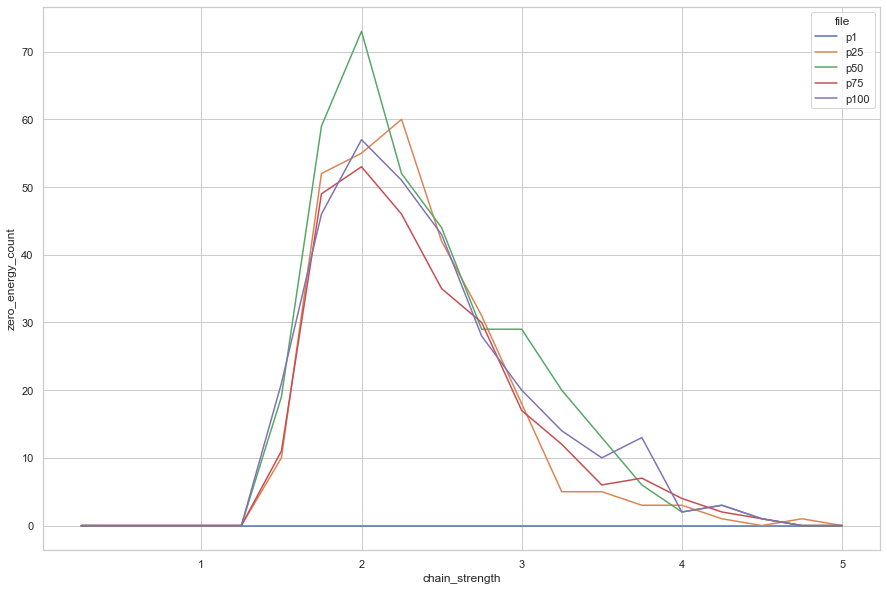

In [72]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=df_energy_0_counts, x="chain_strength", y="zero_energy_count", hue="file")

<AxesSubplot:xlabel='chain_strength', ylabel='zero_energy_count'>

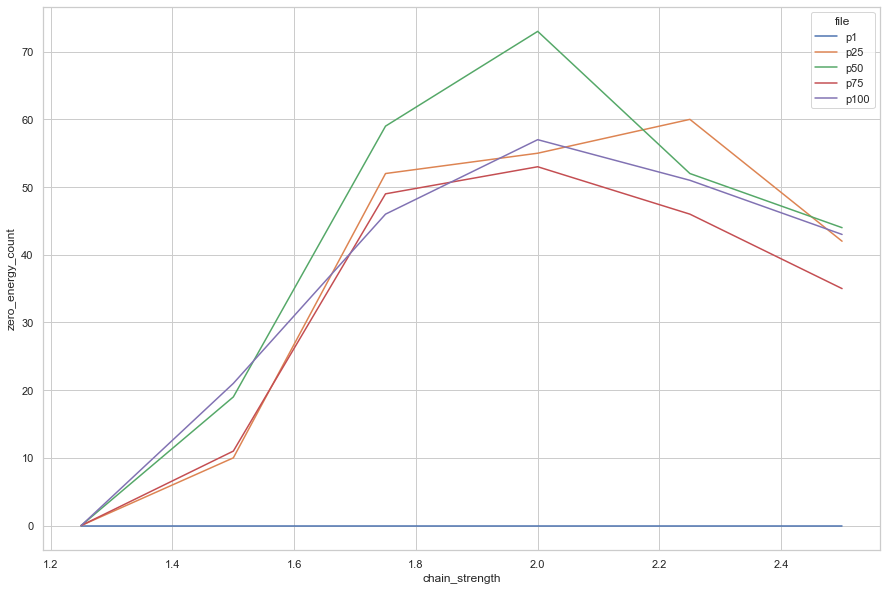

In [82]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
df_temp = df_energy_0_counts[(df_energy_0_counts.chain_strength>1) &( df_energy_0_counts.chain_strength < 2.75)]
sns.lineplot(data=df_temp, x="chain_strength", y="zero_energy_count", hue="file")

In [ ]:
# next tests over 1.5 -> 2.25 (included)